# EXP.05 캐글, 랭킹을 올리자! 뭘 할 수 있을까? 

* 이번 EXP 에선 캐글 대회를 간접적으로 체험 해 보고, 데이터 전처리를 통해 점수를 올려보는 시도를 해 보았다. EXP 예제에서 시도 해 보지 못한 방법으로, 점수를 기준치에 맞춰보자! 

----



# <span style="color:red"> 1. 루브릭 평가 기준</span>

**1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?**  
&nbsp;&nbsp;&nbsp;&nbsp;데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.
    

**2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?**  
&nbsp;&nbsp;&nbsp;&nbsp;제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.


**3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?**   
&nbsp;&nbsp;&nbsp;&nbsp;다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

 ----
 
 
 

# 2. 실험 전 데이터 준비하기 

##  &nbsp;&nbsp; 2-1 필요한 모듈 불러오기

In [79]:
#시각화 라이브러리 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy import stats #Analysis 

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

# 4가지 모델 가져오기 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 그리드 탐색
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

print('모듈을 불러오는 데 성공하였습니다:D ')


모듈을 불러오는 데 성공하였습니다:D 


##  &nbsp;&nbsp; 2-2 함수 정리 

* lms 에서 함수화 했던 부분을 정리했습니다. 

In [119]:
#rmse 계산 함수 
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [120]:
# get_scores : 각 모델별 RMSE 값을 계산해서 출력 해 주는 함수 

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [82]:
# my_GridSearch 함수! 설명은 아래와 같습니다

"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [140]:
# save_submission 함수 선언

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

##  &nbsp; &nbsp;2-2 데이터 준비하기 

### &nbsp;&nbsp;&nbsp;&nbsp; 2-2-1 데이터 가져오기 

In [84]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

ob_train = pd.read_csv(train_data_path)
ob_test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(ob_train.shape))
print('test data dim : {}'.format(ob_test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [85]:
#가져온 데이터를 살펴봅니다.
ob_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


* 각 변수에 대한 설명은 이쪽을 참고해 이해 해 보았습니다.
[House Price Prediction 변수](https://www.kaggle.com/cookierhkwk/eda-house-price-prediction-eda?scriptVersionId=12305839) 

### &nbsp;&nbsp;&nbsp;&nbsp; 2-2-2 가져온 데이터의 Data fields 확인하기 


* ID : 집을 구분하는 번호
* date : 집을 구매한 날짜
* price : 집의 가격(Target variable)
* bedrooms : 침실의 수
* bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
* sqft_living : 주거 공간의 평방 피트(면적)
* sqft_lot : 부지의 평방 피트(면적)
* floors : 집의 층 수
* waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
* view : 집이 얼마나 좋아 보이는지의 정도
* condition : 집의 전반적인 상태
* grade : King County grading 시스템 기준으로 매긴 집의 등급
* sqft_above : 지하실을 제외한 평방 피트(면적)
* sqft_basement : 지하실의 평방 피트(면적)
* yr_built : 지어진 년도
* yr_renovated : 집을 재건축한 년도
* zipcode : 우편번호
* lat : 위도
* long : 경도
* sqft_living15 : 2015년 기준 주거 공간의 평방 피트  
(면적, 집을 재건축했다면, 변화가 있을 수 있음)
* sqft_lot15 : 2015년 기준 부지의 평방 피트  
(면적, 집을 재건축했다면, 변화가 있을 수 있음)



### &nbsp;&nbsp;&nbsp;&nbsp; 2-2-3 목적 변수 price 시각화 


* 집값의 경우 집을 구매한 시점의 가격 = 현재의 가격을 반영하는 것이 아님, 고쳤어도 집의 가격에는 영향을 주지 못합니다. 

In [86]:
ob_train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


<AxesSubplot:xlabel='price', ylabel='Density'>

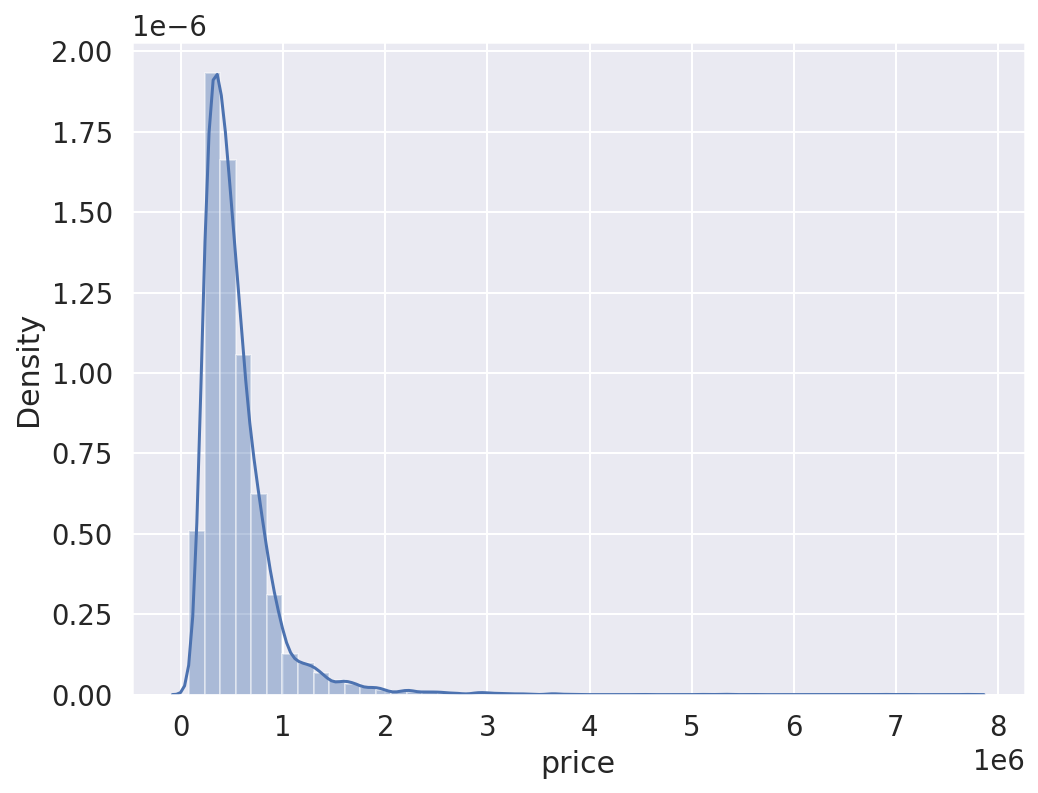

In [87]:
# 그래프로 그려서 분포를 확인 해봅시다. 
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(ob_train['price'])

* 가격 데이터의 분포가 치우친것을 확인해볼 수있음. 


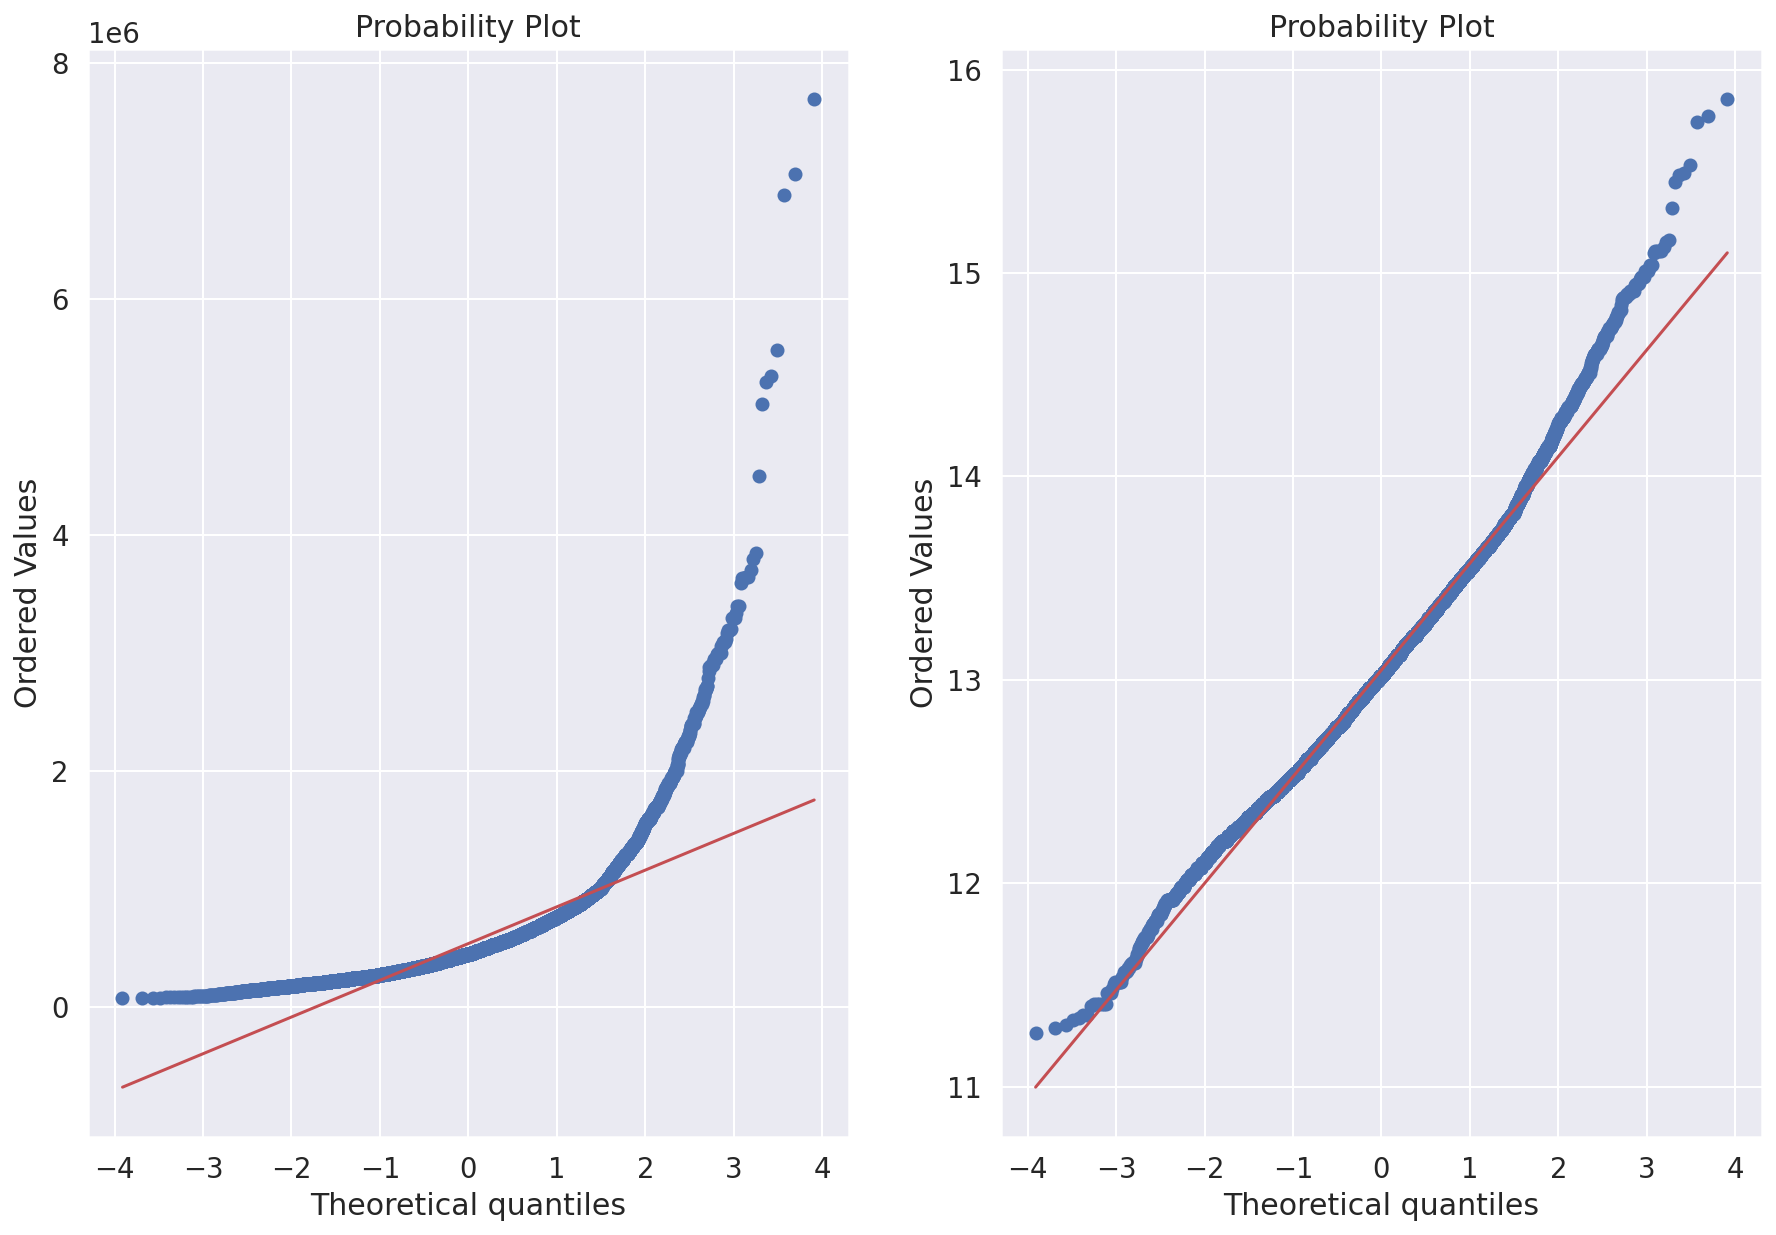

In [88]:
# log를 취했을때, 취하지 않았을때의 그래프 비교

fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(ob_train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(ob_train['price']), plot=plt)



* 위 그래프로, log를 취해줬을 때, 기존보다 더 정규성을 가지는 것을 확인할 수있음. 
* log 를 취해 분포를 정규화 시켜줍니다. 

<AxesSubplot:xlabel='price', ylabel='Density'>

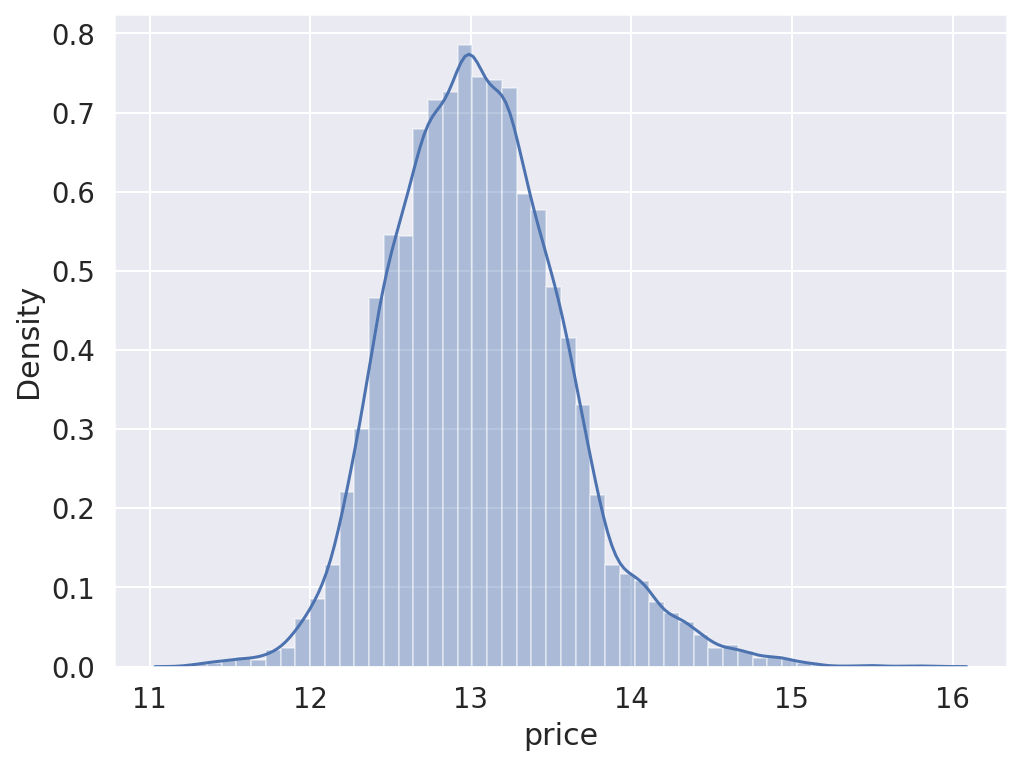

In [89]:
# 값 데이터 정규화 
ob_train['price'] = np.log1p(ob_train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(ob_train['price'])

### &nbsp;&nbsp;&nbsp;&nbsp; 2-2-4 반응변수 시각화

* 가격과 가장 상관관계가 높은 순서대로 순위 상관관계를 본 히트맵 
* 상관도가 높은 상위 10개의 값만 확인 

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

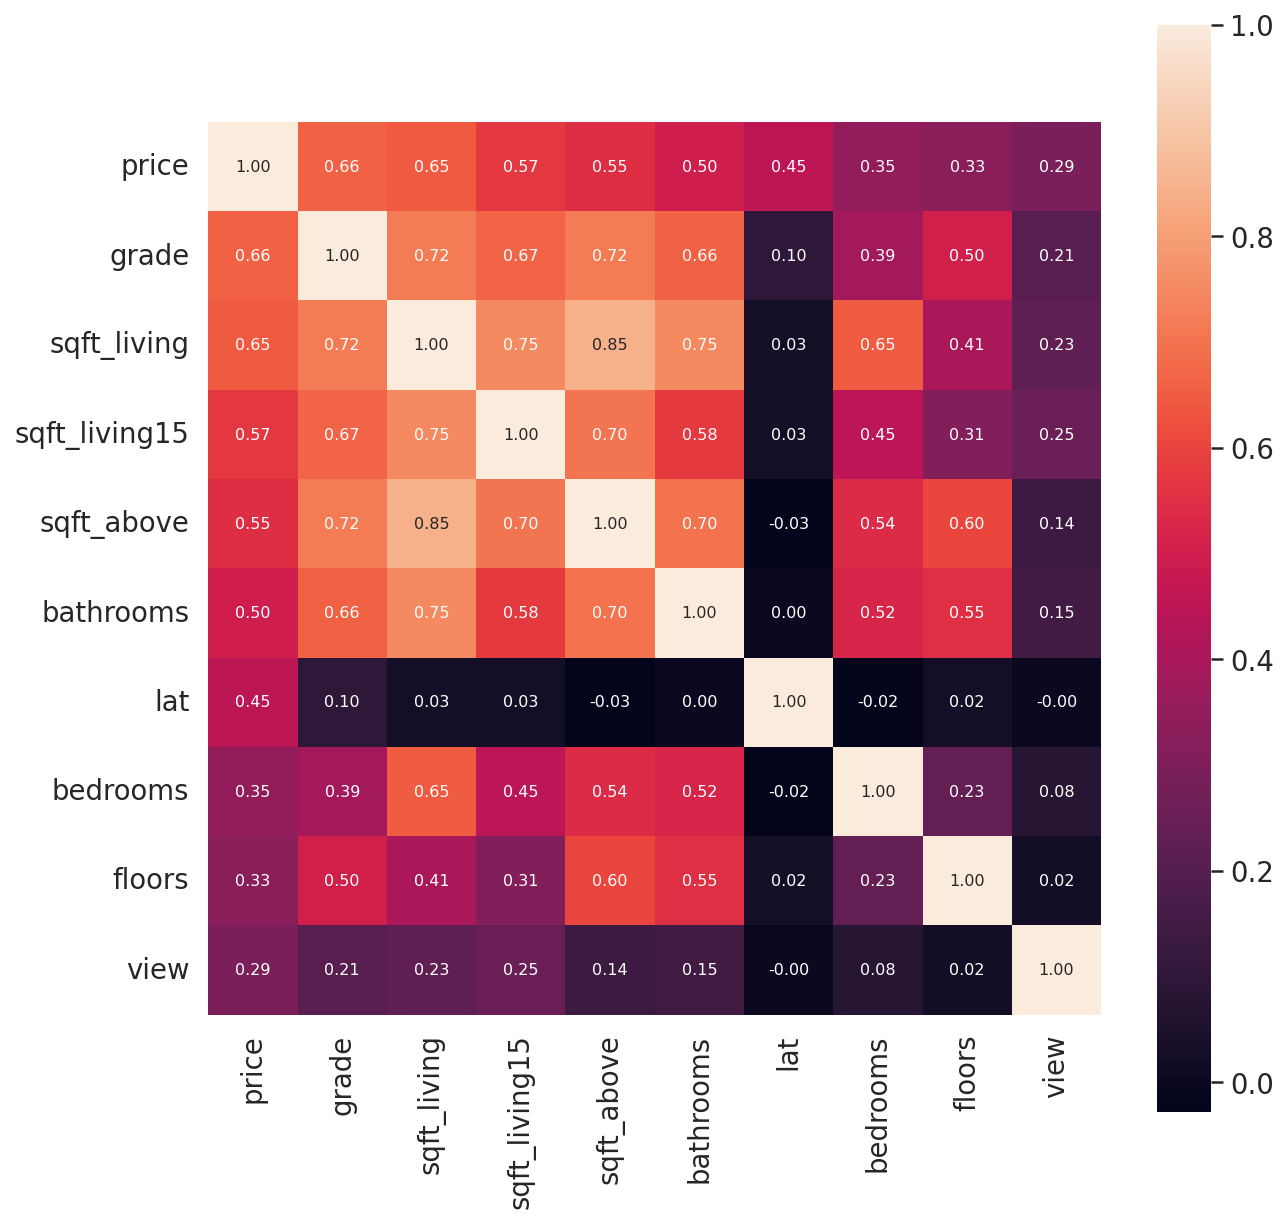

In [90]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
import scipy as sp

cor_abs = abs(ob_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)

# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(ob_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)



* grade 확인 

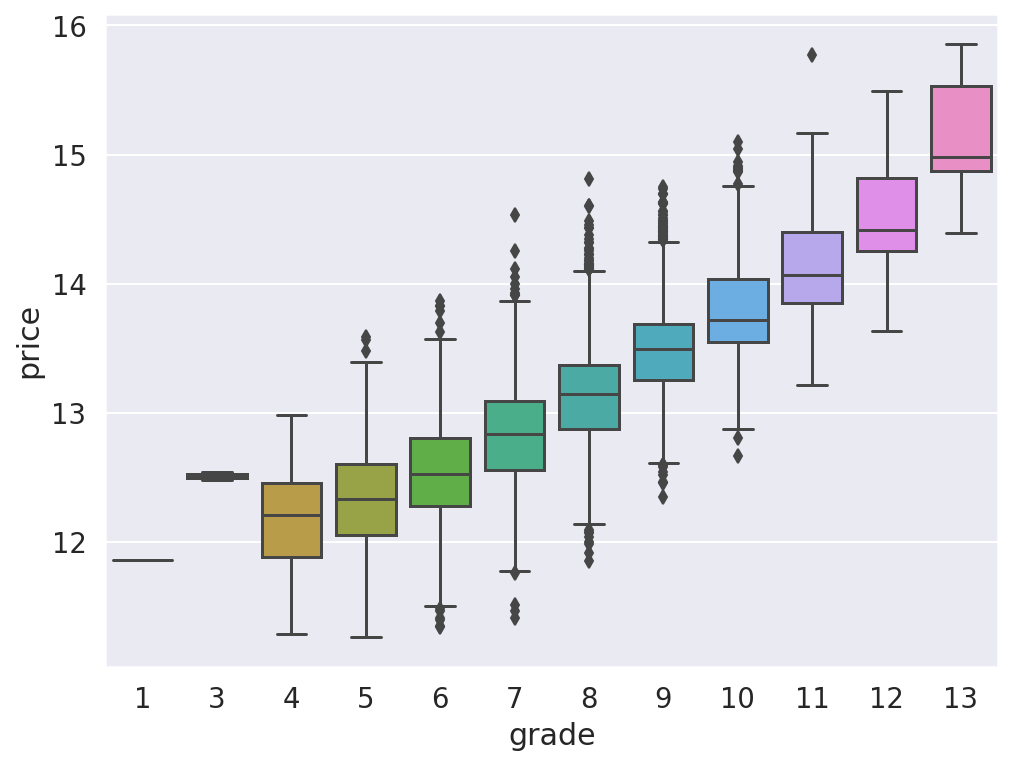

In [91]:
data = pd.concat([ob_train['price'], ob_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

* grade : "1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다." 
* 집의 등급이 높으면 -> 가격이 좋아진다 

* sqlf_living / sqlf_lot (주거 평방 피트 / 부지 평방 피트)

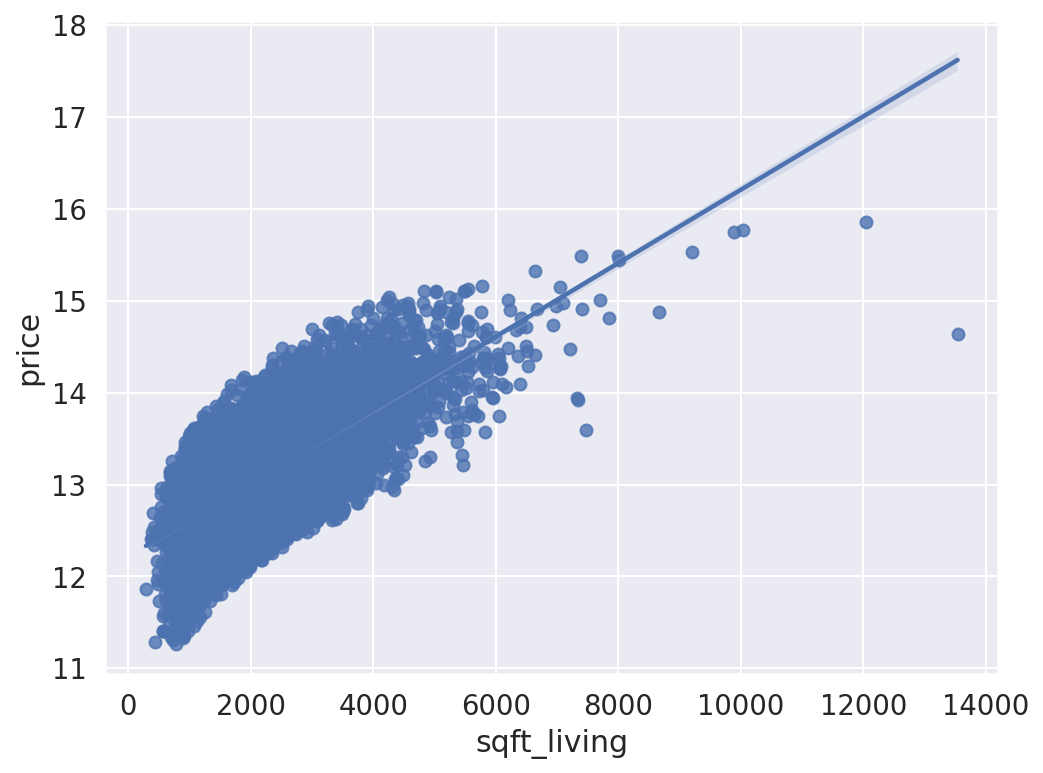

In [92]:
data = pd.concat([ob_train['price'], ob_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

* bathroom 

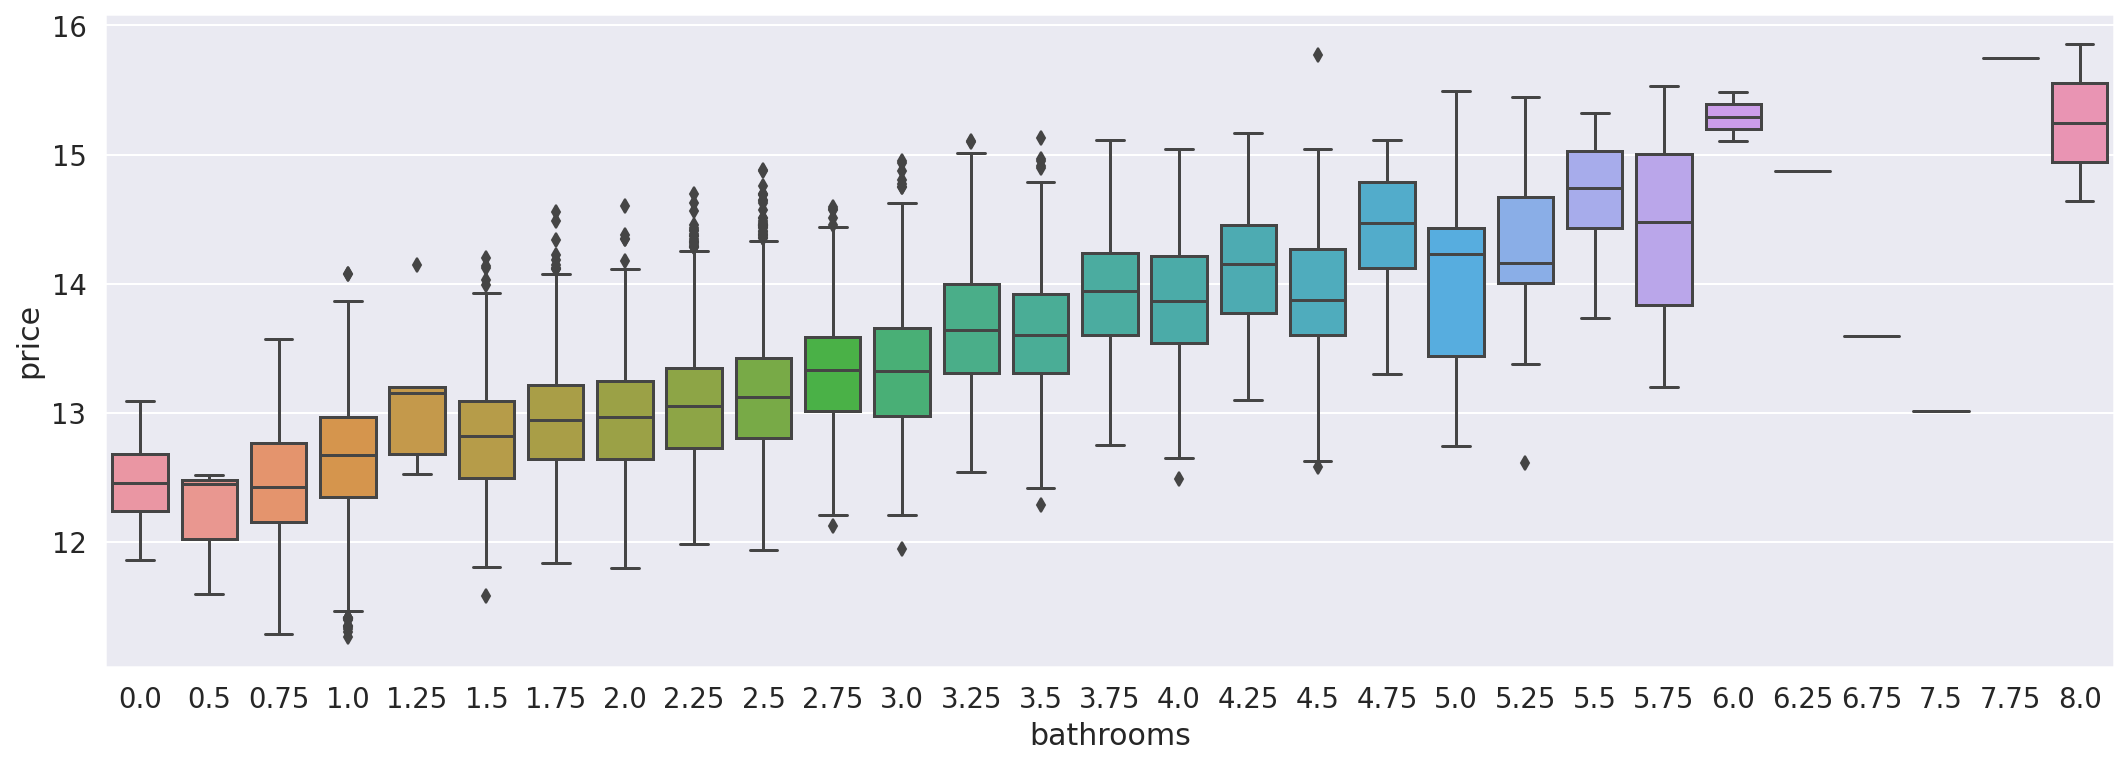

In [93]:
data = pd.concat([ob_train['price'], ob_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

* bedroom

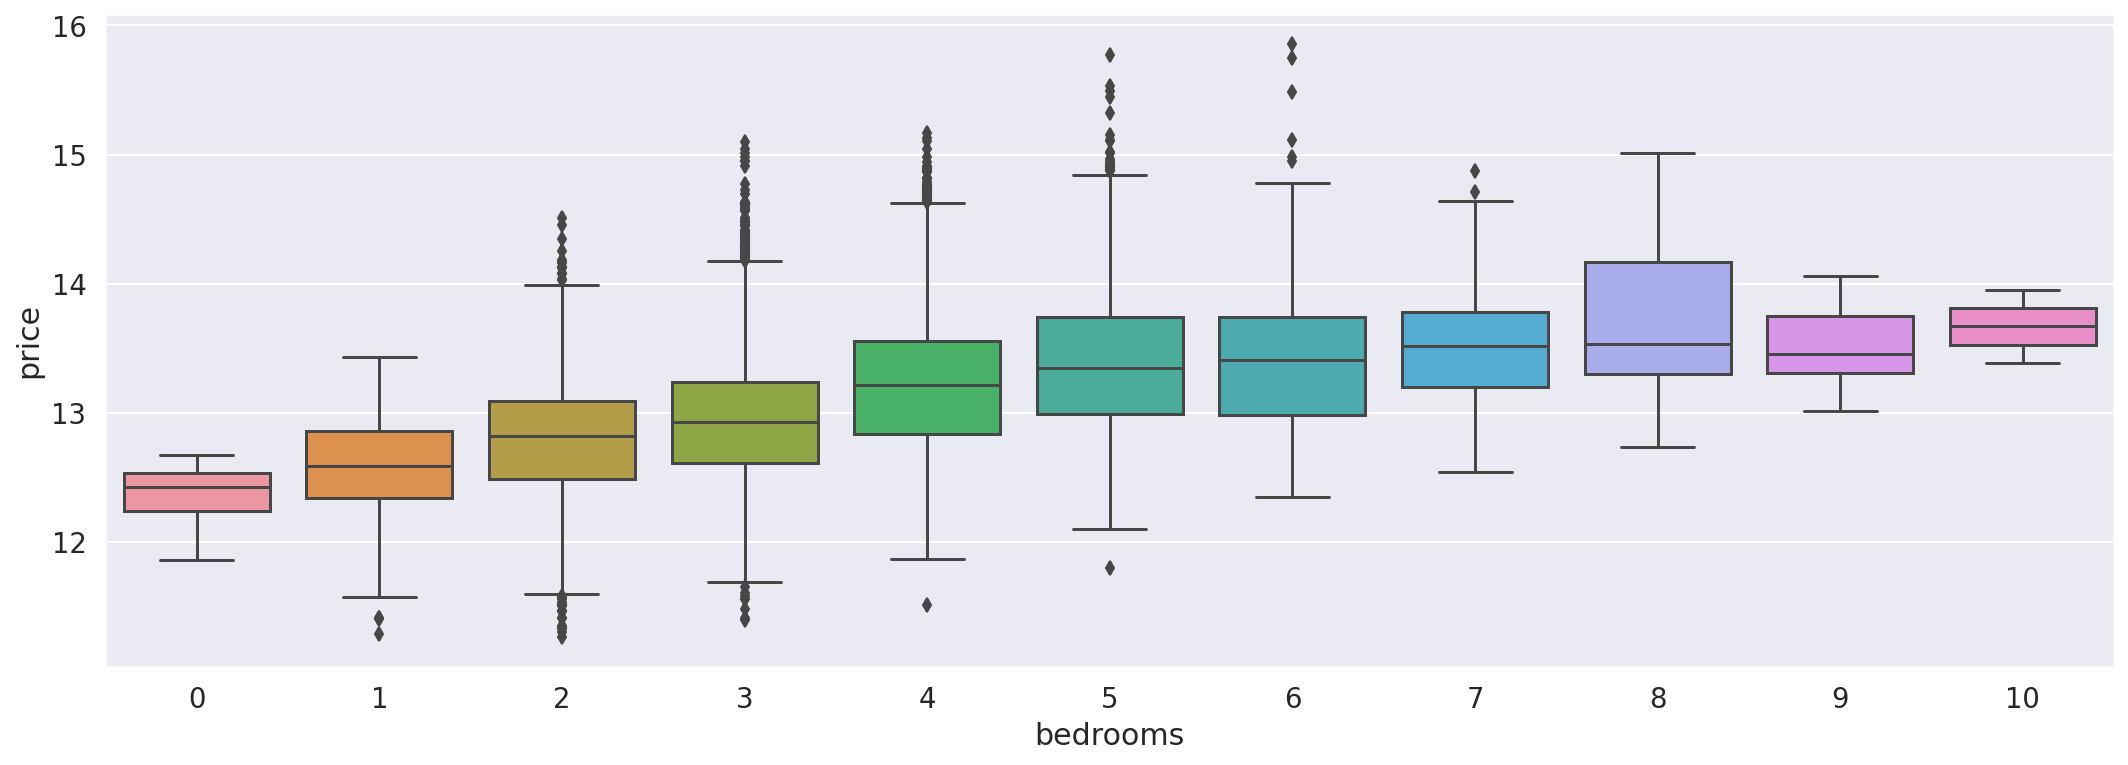

In [94]:
data = pd.concat([ob_train['price'], ob_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

##  &nbsp; &nbsp;2-3 데이터 전처리 하기 


* 가져온 데이터를 전처리 해 주어, 모델이 학습하기 쉽게 가공해주는 단계입니다. 


###  &nbsp; &nbsp;&nbsp; &nbsp; 2-3-1 데이터 결측치 확인 

<AxesSubplot:>

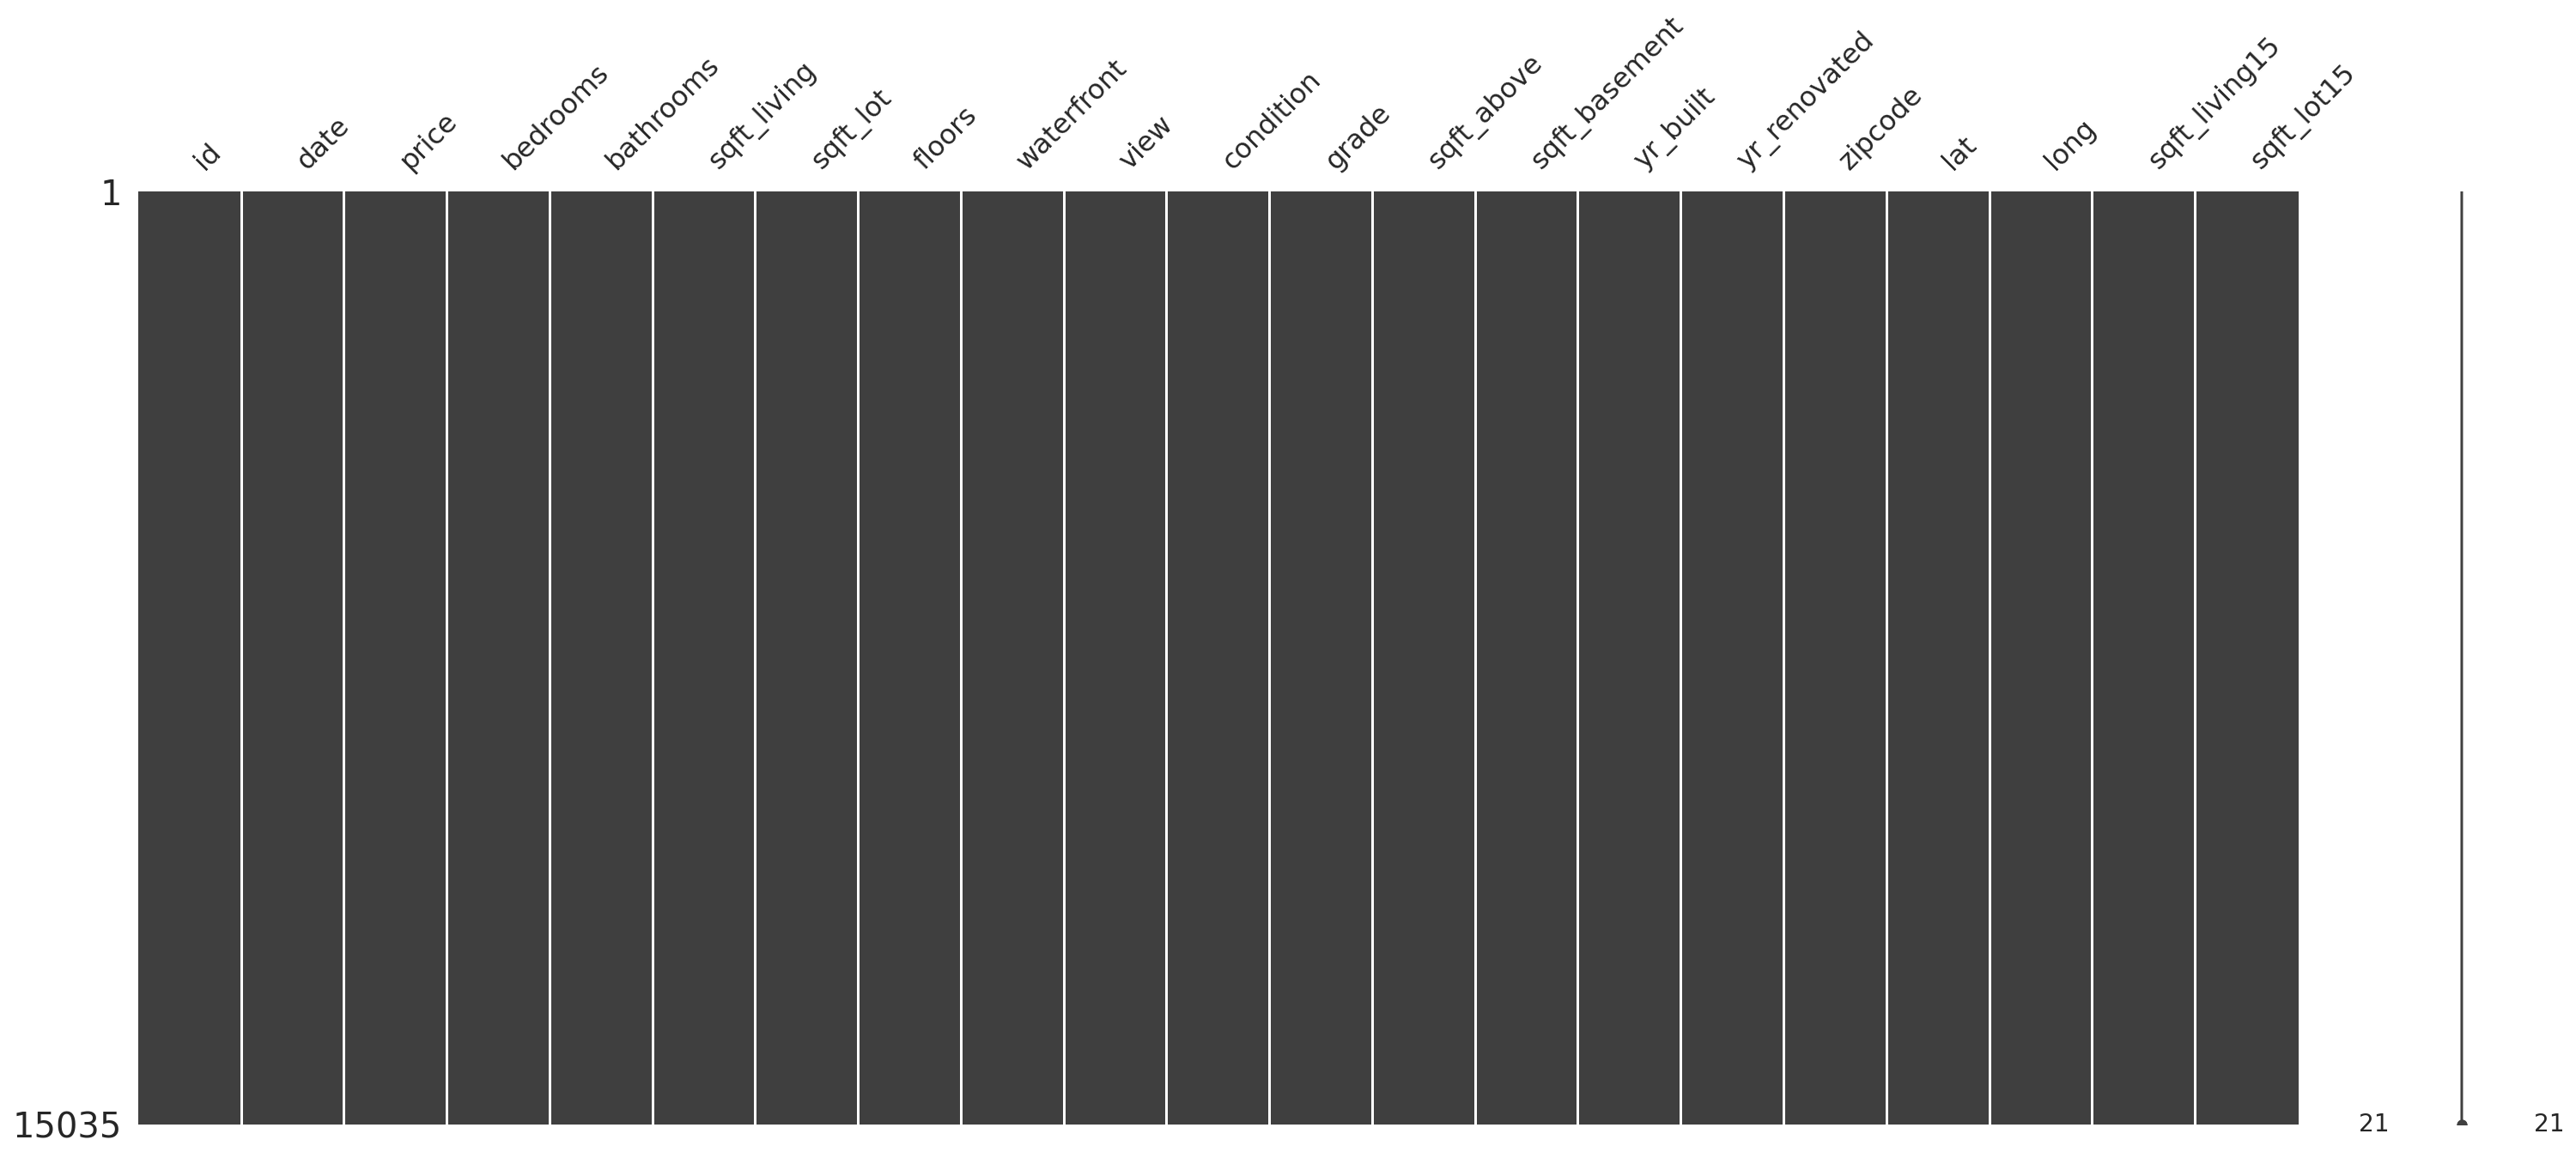

In [95]:
#missingno 를 이용한 확인 
msno.matrix(ob_train)

* missingno로 알아본 데이터에는, 빈 부분이 없는것으로 보아, 데이터의 결측치는 없는것으로 확인되었다.

###  &nbsp; &nbsp;&nbsp; &nbsp; 2-3-2. 데이터 정규화

In [96]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    ob_train[c] = np.log1p(ob_train[c].values)
    ob_test[c] = np.log1p(ob_test[c].values)
    
print('data 정규화 완료!')

data 정규화 완료!


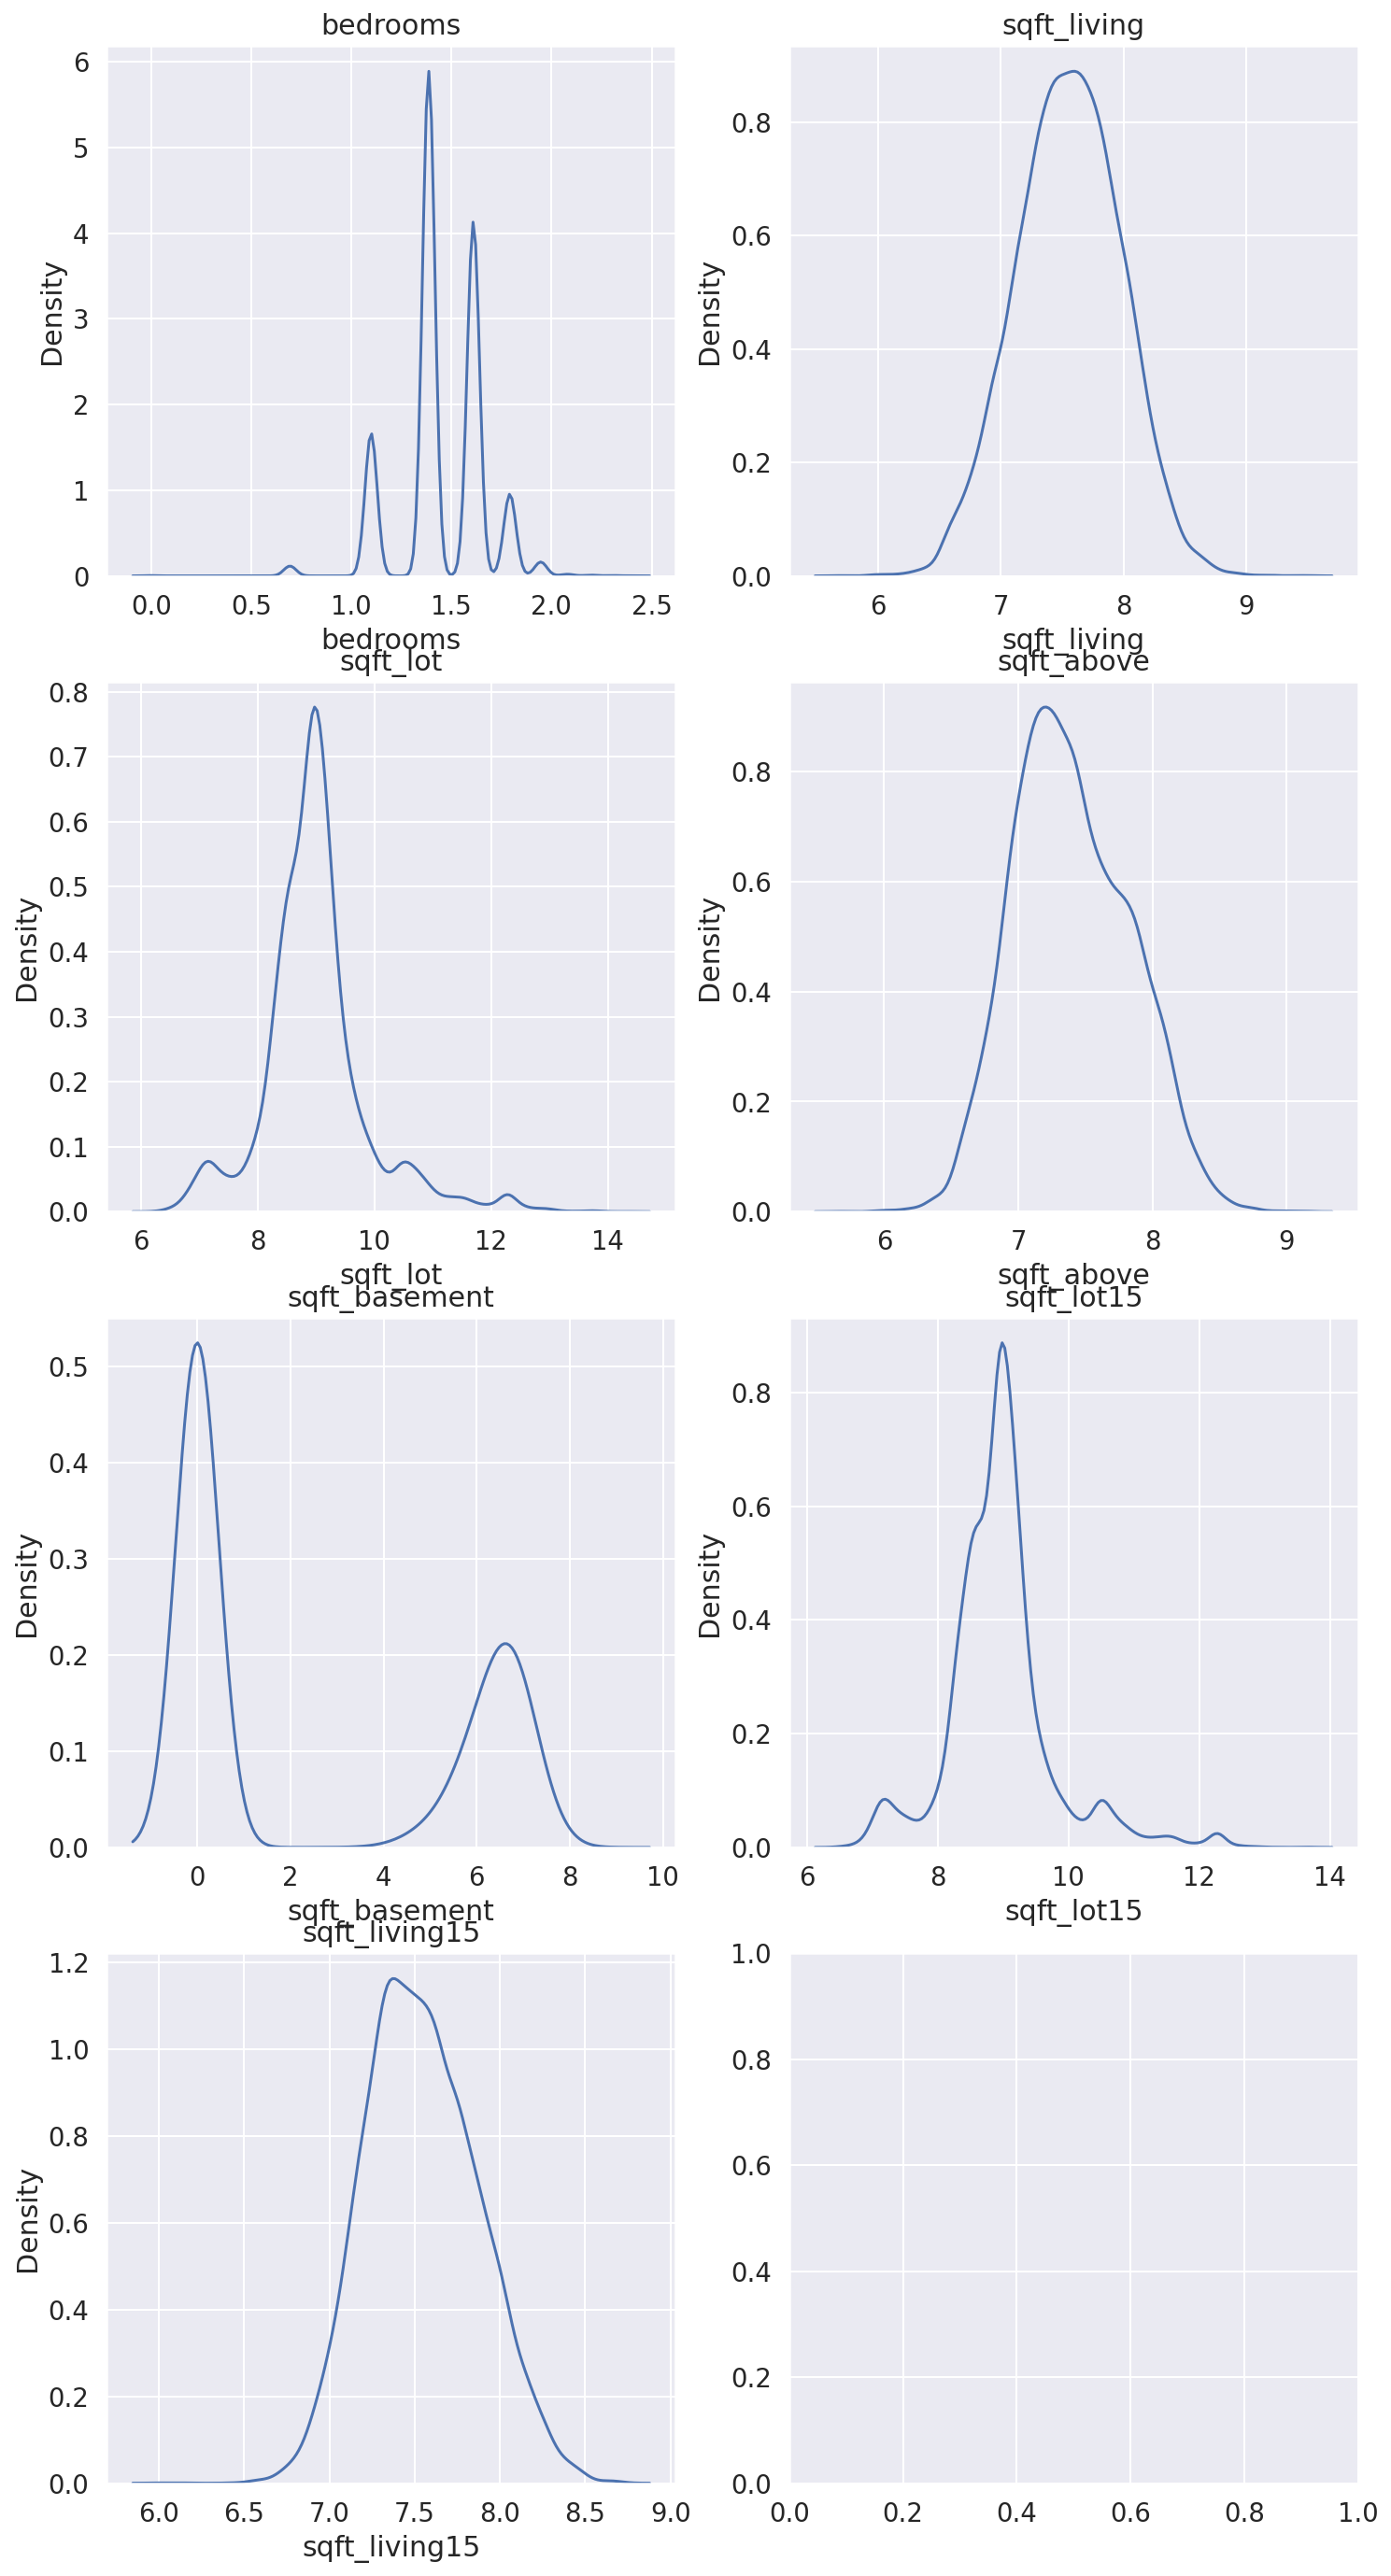

In [97]:
# 정규화가 잘 됬는지 확인! 

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=ob_train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

###  &nbsp; &nbsp;&nbsp; &nbsp; 2-3-4. 변수 수정
* train, test data에서 
    * date 의 불필요한 부분(T이후 부분)을 제거후, 8자리 날짜 데이터로 
    * yr_renovated(재건축년도)에 값이 0이라면 nan을 넣어준 다음, 
    * yr_renovated 에 yr_built 년도를 넣어주는 코드.
    * id 컬럼 삭제 

In [98]:
# date 의 불필요한 부분(T이후 부분)을 제거후, 8자리 날짜 데이터로 
ob_train['date'] = ob_train['date'].apply(lambda i: i[:8]).astype(int)
ob_test['date'] = ob_test['date'].apply(lambda i: i[:8]).astype(int)

In [99]:
for df in [ob_train,ob_test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [100]:
#train data 에 있는 target data 'price'를 y 변수에 저장, train data 에선 삭제 해 줍니다.
y = ob_train['price']
del ob_train['price']

print(ob_train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [108]:
# id 컬럼 삭제 
train_id = ob_train['id']
test_id = ob_test['id']

del ob_train['id']
del ob_test['id']

###  &nbsp; &nbsp;&nbsp; &nbsp; 2-3-5. 변수 생성(확인?)

In [109]:
ob_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,7.201171,8.639588
1,20150225,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,7.908755,8.995041
2,20150218,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,7.496097,8.923191
3,20140627,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,7.713785,8.827615
4,20150115,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,7.409136,9.181118


In [110]:
ob_test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141209,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991.0,98125,47.7210,-122.319,7.433075,8.941153
1,20141209,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,1965.0,98136,47.5208,-122.393,7.215975,8.517393
2,20140512,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,2001.0,98053,47.6561,-122.005,8.468213,11.532051
3,20150415,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,1960.0,98146,47.5123,-122.337,7.484930,9.001346
4,20150312,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,2003.0,98038,47.3684,-122.031,7.779467,8.932080


In [111]:
# 변수 생성 후, train data check! 
default_check = pd.concat([ob_train.isnull().sum(), 
                           ob_train.dtypes, ob_train.nunique(), 
                           ob_train.describe().T],axis=1)
default_check.rename(columns={0:'NULL', 1:'TYPE', 2:'UNIQUE'}, inplace=True)
default_check


,NULL,TYPE,UNIQUE,count,mean,std,min,25%,50%,75%,max
date,0,int64,365,15035.0,2.014387e+07,4425.130513,2.014050e+07,2.014072e+07,2.014102e+07,2.015021e+07,2.015051e+07
bedrooms,0,float64,11,15035.0,1.452912e+00,0.210784,0.000000e+00,1.386294e+00,1.386294e+00,1.609438e+00,2.397895e+00
bathrooms,0,float64,29,15035.0,2.115065e+00,0.767519,0.000000e+00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,0,float64,863,15035.0,7.552362e+00,0.425656,5.673323e+00,7.266129e+00,7.555382e+00,7.848153e+00,9.513477e+00
sqft_lot,0,float64,7678,15035.0,8.992803e+00,0.905809,6.255750e+00,8.522877e+00,8.938663e+00,9.277672e+00,1.431711e+01
floors,0,float64,6,15035.0,1.498071e+00,0.538522,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,0,int64,2,15035.0,7.116728e-03,0.084063,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,0,int64,5,15035.0,2.342534e-01,0.763376,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,0,int64,5,15035.0,3.406651e+00,0.646505,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
grade,0,int64,12,15035.0,7.660725e+00,1.179803,1.000000e+00,7.000000e+00,7.000000e+00,8.000000e+00,1.300000e+01


----



# 4. 모델 학습 부터 test까지 

In [ ]:
# 탐색할 parameter 준비
param_grid = {
    'boosting' : ['goss'],#실행 하고자 하는 알고리즘 타입 
    'n_estimators': [1400, 1600, 2000],#반복 수행하는 트리의 개수 
    'max_depth': [5, 7, 9, 11, 13], # Tree의 최대 깊이 
    'learning_rate': [0.015, 0.018, 0.021, 0.024]
    #'num_leaves' : [127, 255, 511] # 1개의 트리가 가질 수 있는 최대 잎의 수, 모델의 복잡도가 증가할 수 있음.
}

In [121]:
#random_state값 
random_state=66     
#Light GBM 
#leaf-wise 방식을 취하고 있기 때문에 수렴이 굉장히 빠르지만,
#파라미터 조정에 실패할 경우 과적합을 초래할 수 있다.
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, ob_train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   4.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   3.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1600; total time=   5.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1600; total time=   5.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boost

,boosting,learning_rate,max_depth,n_estimators,score,RMSLE
6,goss,0.015,9,1400,-0.025756,0.160487
5,goss,0.015,7,2000,-0.025756,0.160488
9,goss,0.015,11,1400,-0.025757,0.160490
4,goss,0.015,7,1600,-0.025758,0.160493
19,goss,0.018,7,1600,-0.025759,0.160496
7,goss,0.015,9,1600,-0.025760,0.160500
18,goss,0.018,7,1400,-0.025765,0.160515
13,goss,0.015,13,1600,-0.025767,0.160520
10,goss,0.015,11,1600,-0.025774,0.160544
12,goss,0.015,13,1400,-0.025779,0.160557


[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.024, max_depth=7, n_estimators=2000; total time=   8.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.024, max_depth=7, n_estimators=2000; total time=   6.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.024, max_depth=9, n_estimators=1400; total time=   4.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.024, max_depth=9, n_estimators=1400; total time=   4.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.024, max_depth=9, n_estimators=1600;

* greed search로 찾은 값들을 get score 함수로 모델별로 학습 및 예측 해 봅니다. 

In [135]:
# 실험할 모델 만들어서 한 곳에 정리 
   
xgboost = XGBRegressor(learning_rate=0.024, max_depth=8, n_estimators=1000, random_state=random_state)
lightgbm0 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=9, n_estimators=1400, random_state=random_state)
lightgbm1 = LGBMRegressor(boosting='gbdt', learning_rate=0.015, max_depth=7, n_estimators=2000, random_state=random_state)
lightgbm2 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=11, n_estimators=1400, random_state=random_state)
lightgbm3 = LGBMRegressor(boosting='gbdt', learning_rate=0.015, max_depth=7, n_estimators=1600, random_state=random_state)
lightgbm4 = LGBMRegressor(boosting='goss', learning_rate=0.018, max_depth=7, n_estimators=1600, random_state=random_state)



In [136]:
get_scores([xgboost, lightgbm0, lightgbm1, lightgbm2, lightgbm3, lightgbm4], ob_train, y)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


,RMSE
LGBMRegressor,106451.503591
XGBRegressor,105808.099325


In [141]:
# 1. 모델을 `train`, `y`로 학습시킵니다.
# 2. `test`에 대해 예측합니다.
# 3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
# LGBMRegressor
save_submission(lightgbm4, ob_train, y, ob_test, 'lgbm', rmsle='106451')

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_106451.csv saved!


In [143]:
# XGBRegressor
save_submission(xgboost, ob_train, y, ob_test, 'XGB', rmsle='105808')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_105808.csv saved!


## 2019 2nd ML month with KaKR Late submission

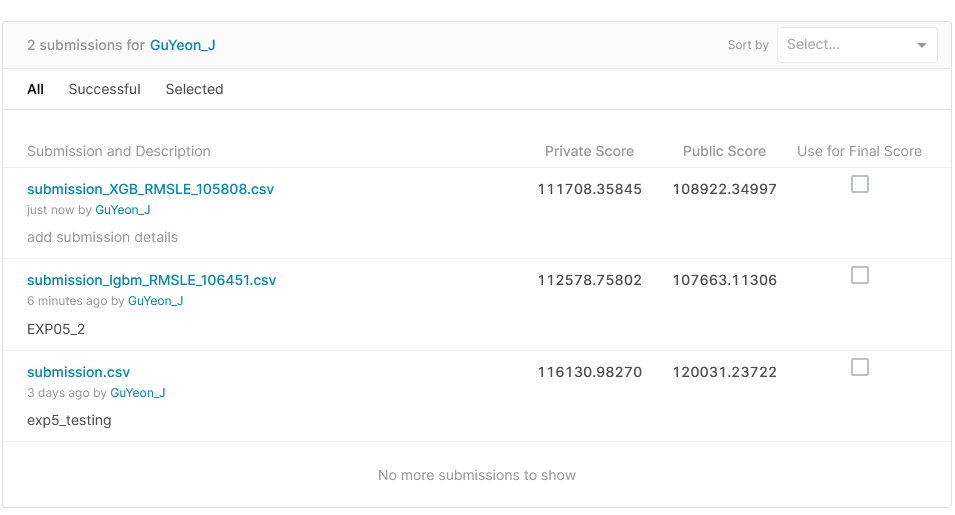






----

# 이번 EXP를 마치며 


* 시각화 데이터 분석하는게 아직도 많이 어려웠다. 그래프를 보고 이게 어떤 자료인지, 무엇을 뜻하며, 이 처리를 해 주는 이유가 무엇인가 를 아직 확연히 잘 모르겠다. 시각화 데이터가 있어야 보기가 쉽다 라는 얘길 이전 회고에서 적었던 것 같은데, 내용 이해가 되지 않는 상황에서 그래프만 가져와서 이렇습니다! 하면 솔직히 나라도 이해 못할텐데.. 


* 점점 느끼는 부분이지만, 정리해서 차근차근 따라가는 것도 중요하지만, 코드를 쳐서 실행 시켜가며 이해 하는것도 중요하단걸 깨달았다. 나중에 보기 위해 깔끔하게 정리 하려는 것도 중요하지만, 코드를 따라서 실행 시켜보고, 또 그 결과값을 보면서 이해한 다음, 다른 여러 시도를 해 보는것도 나중에라도 내가 써 먹을때 하나라도 더 생각 나지 않을까?


* 이번노드 너무.... 어려웠어요.... 다른 분들이 하신 부분이 참고로 엄청많이 들어간 제 프로젝트입니다... 정말정말 많이 부족하고, 이해하기 힘들었던 부분이 많았다고 생각합니다. (시간도 적었지만)  그치만 조금더 익숙해 지고, 모델을 학습하는걸 많이 연습하다보면 더 재밌게 튜닝 해 볼 수 있지않을까요...? 

# 참고 페이지


* [기본적인 코드 참고](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12?scriptVersionId=12697460)


* [정규화 코드 링크](https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline)


* [Light LGB 파라미터 소개](https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/)



* [Light LGB n_estimators](https://greeksharifa.github.io/machine_learning/2019/12/09/Light-GBM/)
